<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import random
import sys
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from keras.regularizers import l2
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, GRU, LSTM, Bidirectional
from keras.layers import SimpleRNN, Embedding
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [3]:
with open('Harry_Potter_Book1.txt', encoding="utf8") as f:
    text_list = f.readlines()

In [4]:
text_list[:20]

['/ \n',
 '\n',
 '\n',
 '\n',
 '\n',
 'THE BOY WHO LIVED \n',
 '\n',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, \n',
 'were proud to say that they were perfectly normal, \n',
 'thank you very much. They were the last people you’d \n',
 'expect to be involved in anything strange or \n',
 'mysterious, because they just didn’t hold with such \n',
 'nonsense. \n',
 '\n',
 'Mr. Dursley was the director of a firm called \n',
 'Grunnings, which made drills. He was a big, beefy \n',
 'man with hardly any neck, although he did have a \n',
 'very large mustache. Mrs. Dursley was thin and \n',
 'blonde and had nearly twice the usual amount of \n',
 'neck, which came in very useful as she spent so \n']

In [5]:
text_list[-20:]

['\n',
 '\n',
 '\n',
 'Page | 347 Harry Potter and the Philosophers Stone - J.K. Rowling \n',
 '\n',
 '\n',
 '\n',
 '\n',
 '“Oh, I will,” said Harry, and they were surprised at \n',
 'the grin that was spreading over his face. “ They don’t \n',
 'know we’re not allowed to use magic at home. I’m \n',
 'going to have a lot of fun with Dudley this summer...” \n',
 '\n',
 '\n',
 '\n',
 'Page | 348 Harry Potter and the Philosophers Stone - J.K. Rowling \n',
 '\n',
 '\n',
 '\n',
 '\n']

In [6]:
def wordcloud_creation(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, collocations=False).generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

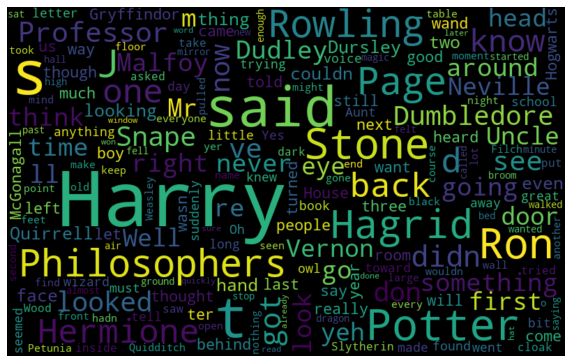

In [7]:
text_string = (" ").join(text_list)
wordcloud_creation(text_string)

In [8]:
print("Total number of lines from text file: {:,}".format(len(text_list)))

Total number of lines from text file: 15,260


In [9]:
def character_counter(item):
    total_character_count = 0
    for line in item:
        total_character_count += len(line)
    return total_character_count

In [10]:
print("Total number of character from text file: {:,}".format(character_counter(text_list)))

Total number of character from text file: 474,429


### 1.2 Data Processing


In [11]:
combined_text = ''
for line in text_list:
    combined_text += line

In [12]:
print("The unique characters before data cleaning:", sorted(set(combined_text)))

The unique characters before data cleaning: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '—', '‘', '’', '“', '”', '•', '■']


In [13]:
def preprocessing(text_input):
    parsed_text = []
    for line in text_input:
        # remove lines that start with 'Page | 342...'
        if line.startswith('Page | '):
            line = ''
        else:
            # Lowercase and remove trailing spaces including \n
            line = line.lower().strip()
            # remove characters that are not words or spaces
            line = re.sub(r'[^\w\s]', '', line)
            # remove digits including those connected to words
            line = re.sub("\d+", "", line)
            # replace more than 1 space to a single space
            line = re.sub(' +', ' ', line)
            # removing word contraction (aren't -> are not)
            line = contractions.fix(line)
            # perform tokenization
            tokenized_line = word_tokenize(line)
            # perform lemmatization to group inflected form of words
            lemmatized_sentence = []
            lemmatizer = WordNetLemmatizer()
            for word in tokenized_line:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, pos='v'))
            line = ' '.join(lemmatized_sentence)
        # only append lines if they are not empty spaces
        if line != '':
            parsed_text.append(line)
    return parsed_text

In [14]:
parsed_text = preprocessing(text_list)

In [15]:
combined_text = ''
for line in parsed_text:
    combined_text += line

In [16]:
print("The unique characters before data cleaning:", sorted(set(combined_text)))

The unique characters before data cleaning: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [17]:
parsed_text[:20]

['the boy who live',
 'mr and mrs dursley of number four privet drive',
 'be proud to say that they be perfectly normal',
 'thank you very much they be the last people you would',
 'expect to be involve in anything strange or',
 'mysterious because they just do not hold with such',
 'nonsense',
 'mr dursley be the director of a firm call',
 'grunnings which make drill he be a big beefy',
 'man with hardly any neck although he do have a',
 'very large mustache mrs dursley be thin and',
 'blonde and have nearly twice the usual amount of',
 'neck which come in very useful as she spend so',
 'much of her time crane over garden fence spy',
 'on the neighbor the dursley s have a small son',
 'call dudley and in their opinion there be no finer',
 'boy anywhere',
 'the dursleys have everything they want but they',
 'also have a secret and their greatest fear be that',
 'somebody would discover it they do not think they']

In [18]:
parsed_text[-20:]

['oh it be nothing dear',
 'ready be you',
 'it be uncle vernon still purplefaced still',
 'mustached still look furious at the nerve of harry',
 'carry an owl in a cage in a station full of ordinary',
 'people behind him stand aunt petunia and dudley',
 'look terrify at the very sight of harry',
 'you must be harry family say mrs weasley',
 'in a manner of speak say uncle vernon hurry',
 'up boy we have not get all day he walk away',
 'harry hang back for a last word with ron and',
 'hermione',
 'see you over the summer then',
 'hope you have er a good holiday say',
 'hermione look uncertainly after uncle vernon',
 'shock that anyone could be so unpleasant',
 'oh i will say harry and they be surprise at',
 'the grin that be spread over his face they do not',
 'know be not allow to use magic at home i be',
 'go to have a lot of fun with dudley this summer']

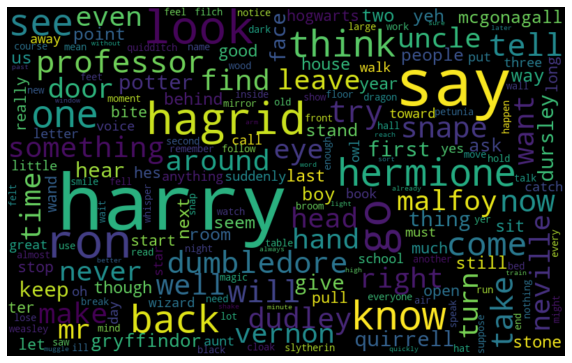

In [19]:
text_string = (' ').join(parsed_text)
wordcloud_creation(text_string)

In [20]:
print("Total number of lines from parsed text file: {:,}".format(len(parsed_text)))

Total number of lines from parsed text file: 9,792


In [21]:
print("Total number of character from parsed text file: {:,}".format(character_counter(parsed_text)))

Total number of character from parsed text file: 387,654


In [22]:
# Length of extracted character sequences
maxlen = 35

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text_string) - maxlen, step):
    sentences.append(text_string[i: i + maxlen])
    next_chars.append(text_string[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print()
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])
print()
print('sentences[2]: ',sentences[2])
print('next_chars[2]: ',next_chars[2])
print()
print('sentences[3]: ',sentences[3])
print('next_chars[3]: ',next_chars[3])
print()
# List of unique characters in the corpus
chars = sorted(list(set(text_string)))
print('Unique characters:', len(chars))
print(chars)
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
print(char_indices)

Number of sequences: 132470
sentences[0]:  the boy who live mr and mrs dursley
next_chars[0]:   

sentences[1]:   boy who live mr and mrs dursley of
next_chars[1]:   

sentences[2]:  y who live mr and mrs dursley of nu
next_chars[2]:  m

sentences[3]:  ho live mr and mrs dursley of numbe
next_chars[3]:  r

Unique characters: 27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [23]:
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print()
print('len(x): ',len(x))
print('x[0]: ',x[0])
print()
print('len(y): ',len(y))
print('y[0]: ',y[0])

Vectorization...

len(x):  132470
x[0]:  [[False False False False False False False False False False False False
  False False False False False False False False  True False False False
  False False False]
 [False False False False False False False False  True False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False  True False False False False False False
  False False False False False False False False False False False False
  False False False]
 [ True False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False  True False False Fa

In [24]:
x.shape

(132470, 35, 27)

In [25]:
y.shape

(132470, 27)

## Step 2 – Develop Character Generator Model

In [26]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

## 1.1 - Basic Stacked LSTM Model

In [27]:
model_lstm = keras.models.Sequential()
model_lstm.add(layers.LSTM(64, input_shape=(maxlen, len(chars)), return_sequences=True))
model_lstm.add(layers.LSTM(64, return_sequences=True))
model_lstm.add(layers.LSTM(64, return_sequences=False))
model_lstm.add(layers.Dense(128, activation='relu'))
model_lstm.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 64)            23552     
                                                                 
 lstm_1 (LSTM)               (None, 35, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 101,403
Trainable params: 101,403
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_lstm.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [29]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 31s 16ms/step - loss: 2.6018 - accuracy: 0.2556 - val_loss: 2.2798 - val_accuracy: 0.3276
Epoch 2/30
880/880 [==============================] - 13s 15ms/step - loss: 2.1412 - accuracy: 0.3623 - val_loss: 2.0373 - val_accuracy: 0.3937
Epoch 3/30
880/880 [==============================] - 15s 17ms/step - loss: 1.9694 - accuracy: 0.4121 - val_loss: 1.9172 - val_accuracy: 0.4231
Epoch 4/30
880/880 [==============================] - 15s 17ms/step - loss: 1.8640 - accuracy: 0.4394 - val_loss: 1.8208 - val_accuracy: 0.4491
Epoch 5/30
880/880 [==============================] - 15s 17ms/step - loss: 1.7824 - accuracy: 0.4610 - val_loss: 1.7478 - val_accuracy: 0.4681
Epoch 6/30
880/880 [==============================] - 15s 18ms/step - loss: 1.7179 - accuracy: 0.4790 - val_loss: 1.6984 - val_accuracy: 0.4832
Epoch 7/30
880/880 [==============================] - 16s 18ms/step - loss: 1.6629 - accuracy: 0.4944 - val_loss: 1.6502 - val_accuracy:

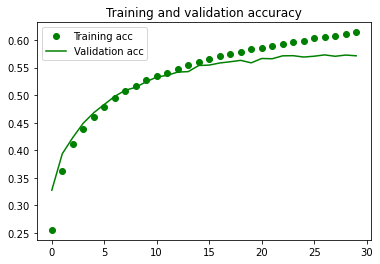

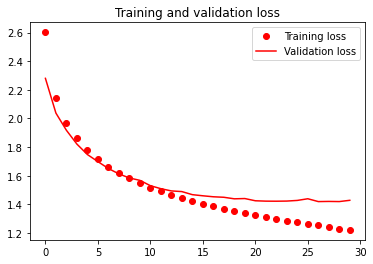

In [30]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_lstm.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "ide except perhaps hogwarts it look"
------ temperature: 0.1
ide except perhaps hogwarts it look at the strange the stone and say harry say harry and the try to be the train and the try to be the strange the stone and the try to be the top he say harry and the strange to the train and the try to say harry and the troll have to see him harry would be so a silver the stone and say harry say harry have note a bite and say harry and the try to say harry and the strange the stone and say harry an
------ temperature: 0.3
ide except perhaps hogwarts it look at the street the shape spen and have a little but the slytherin but he say harry the stone straight and he be a paint and say harry have note because the stone and say harry and so and say harry have not he be a shoulder to be the same that be that have say harry and she be say hagrid have a poke and get the chair but she be so the house this but the stone straight and he be anything and say har
------ temperatu

In [32]:
# Save the Model
model_lstm.save('SeoShinYoun_LSTM1.h5')

## 1.2 - Improved Stacked LSTM Model (Add Dropout = 0.2 for Overfitting)

In [33]:
model_lstm2 = keras.models.Sequential()
model_lstm2.add(layers.LSTM(64, input_shape=(maxlen, len(chars)), return_sequences=True))
model_lstm2.add(layers.Dropout(0.2))

model_lstm2.add(layers.LSTM(64, return_sequences=True))
model_lstm2.add(layers.Dropout(0.2))

model_lstm2.add(layers.LSTM(64, return_sequences=False))
model_lstm2.add(layers.Dropout(0.2))

model_lstm2.add(layers.Dense(128, activation='relu'))
model_lstm2.add(layers.Dropout(0.2))

model_lstm2.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 64)            23552     
                                                                 
 lstm_1 (LSTM)               (None, 35, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 101,403
Trainable params: 101,403
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
optimizer = optimizers.Adam()
model_lstm2.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [37]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm2.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 22s 19ms/step - loss: 2.7283 - accuracy: 0.2262 - val_loss: 2.3981 - val_accuracy: 0.3088
Epoch 2/30
880/880 [==============================] - 14s 16ms/step - loss: 2.2948 - accuracy: 0.3228 - val_loss: 2.1324 - val_accuracy: 0.3609
Epoch 3/30
880/880 [==============================] - 15s 17ms/step - loss: 2.1313 - accuracy: 0.3660 - val_loss: 1.9909 - val_accuracy: 0.4030
Epoch 4/30
880/880 [==============================] - 17s 19ms/step - loss: 2.0290 - accuracy: 0.3946 - val_loss: 1.8907 - val_accuracy: 0.4282
Epoch 5/30
880/880 [==============================] - 15s 17ms/step - loss: 1.9517 - accuracy: 0.4163 - val_loss: 1.8117 - val_accuracy: 0.4464
Epoch 6/30
880/880 [==============================] - 15s 17ms/step - loss: 1.8935 - accuracy: 0.4295 - val_loss: 1.7589 - val_accuracy: 0.4603
Epoch 7/30
880/880 [==============================] - 15s 17ms/step - loss: 1.8482 - accuracy: 0.4419 - val_loss: 1.7118 - val_accuracy:

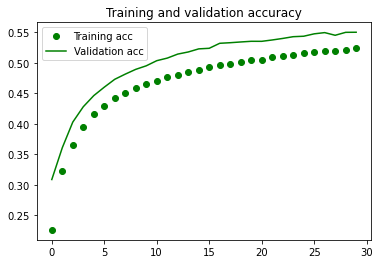

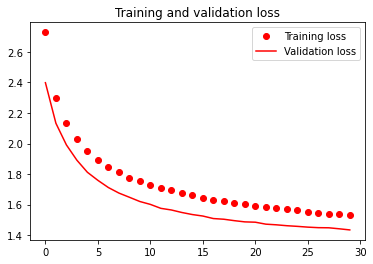

In [38]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
# Save the Model
model_lstm2.save('SeoShinYoun_LSTM2.h5')

## 1.3 - Improved Stacked LSTM Model (Increase Units to tackle Underfitting)

In [43]:
model_lstm3 = keras.models.Sequential()
model_lstm3.add(layers.LSTM(128, input_shape=(maxlen, len(chars)), return_sequences=True))
model_lstm3.add(layers.Dropout(0.2))

model_lstm3.add(layers.LSTM(128, return_sequences=True))
model_lstm3.add(layers.Dropout(0.2))

model_lstm3.add(layers.LSTM(64, return_sequences=False))
model_lstm3.add(layers.Dropout(0.2))

model_lstm3.add(layers.Dense(256, activation='relu'))
model_lstm3.add(layers.Dropout(0.2))

model_lstm3.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 35, 128)           79872     
                                                                 
 dropout_11 (Dropout)        (None, 35, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 35, 128)           131584    
                                                                 
 dropout_12 (Dropout)        (None, 35, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [44]:
optimizer = optimizers.Adam()
model_lstm3.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [45]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm3.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 22s 19ms/step - loss: 2.6237 - accuracy: 0.2482 - val_loss: 2.2507 - val_accuracy: 0.3242
Epoch 2/30
880/880 [==============================] - 18s 20ms/step - loss: 2.1846 - accuracy: 0.3549 - val_loss: 2.0384 - val_accuracy: 0.3910
Epoch 3/30
880/880 [==============================] - 17s 20ms/step - loss: 2.0136 - accuracy: 0.4001 - val_loss: 1.8563 - val_accuracy: 0.4387
Epoch 4/30
880/880 [==============================] - 17s 19ms/step - loss: 1.8941 - accuracy: 0.4314 - val_loss: 1.7696 - val_accuracy: 0.4606
Epoch 5/30
880/880 [==============================] - 19s 22ms/step - loss: 1.8157 - accuracy: 0.4524 - val_loss: 1.6889 - val_accuracy: 0.4832
Epoch 6/30
880/880 [==============================] - 20s 22ms/step - loss: 1.7553 - accuracy: 0.4668 - val_loss: 1.6290 - val_accuracy: 0.4981
Epoch 7/30
880/880 [==============================] - 18s 21ms/step - loss: 1.7053 - accuracy: 0.4805 - val_loss: 1.5921 - val_accuracy:

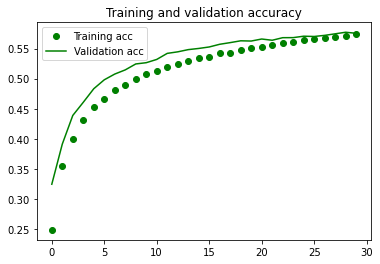

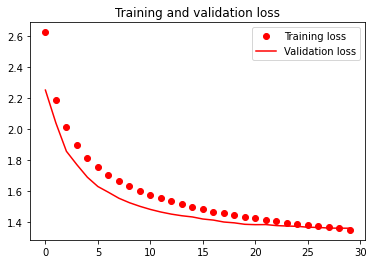

In [46]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
# Save the Model
model_lstm3.save('SeoShinYoun_LSTM3.h5')

## 1.4 - Improved Stacked LSTM Model (Increase Units + Layers for Increase Accuracy)

In [53]:
model_lstm4 = keras.models.Sequential()
model_lstm4.add(layers.LSTM(256, input_shape=(maxlen, len(chars)), return_sequences=True))
model_lstm4.add(layers.Dropout(0.2))

model_lstm4.add(layers.LSTM(256, return_sequences=True))
model_lstm4.add(layers.Dropout(0.2))

model_lstm4.add(layers.LSTM(128, return_sequences=True))
model_lstm4.add(layers.Dropout(0.2))

model_lstm4.add(layers.LSTM(128, return_sequences=False))
model_lstm4.add(layers.Dropout(0.2))

model_lstm4.add(layers.Dense(256, activation='relu'))
model_lstm4.add(layers.Dropout(0.2))

model_lstm4.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 35, 256)           290816    
                                                                 
 dropout_26 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_26 (LSTM)              (None, 35, 256)           525312    
                                                                 
 dropout_27 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_27 (LSTM)              (None, 35, 128)           197120    
                                                                 
 dropout_28 (Dropout)        (None, 35, 128)           0         
                                                                 
 lstm_28 (LSTM)              (None, 128)              

In [54]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_lstm4.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [55]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm4.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 40s 36ms/step - loss: 2.7101 - accuracy: 0.2266 - val_loss: 2.3467 - val_accuracy: 0.2939
Epoch 2/30
880/880 [==============================] - 31s 35ms/step - loss: 2.2492 - accuracy: 0.3248 - val_loss: 2.0707 - val_accuracy: 0.3743
Epoch 3/30
880/880 [==============================] - 32s 37ms/step - loss: 2.0411 - accuracy: 0.3856 - val_loss: 1.8796 - val_accuracy: 0.4239
Epoch 4/30
880/880 [==============================] - 33s 37ms/step - loss: 1.8990 - accuracy: 0.4232 - val_loss: 1.7552 - val_accuracy: 0.4606
Epoch 5/30
880/880 [==============================] - 33s 37ms/step - loss: 1.8020 - accuracy: 0.4520 - val_loss: 1.6777 - val_accuracy: 0.4825
Epoch 6/30
880/880 [==============================] - 34s 38ms/step - loss: 1.7317 - accuracy: 0.4691 - val_loss: 1.6149 - val_accuracy: 0.4996
Epoch 7/30
880/880 [==============================] - 35s 40ms/step - loss: 1.6744 - accuracy: 0.4853 - val_loss: 1.5653 - val_accuracy:

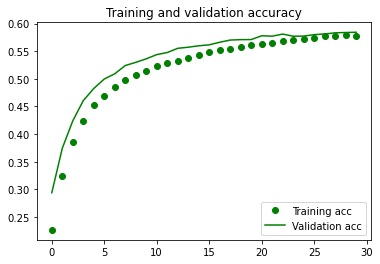

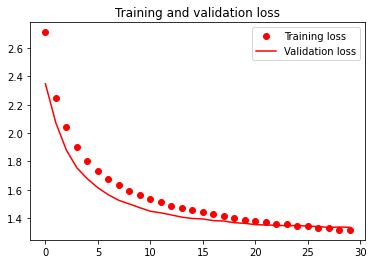

In [56]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [57]:
# Save the Model
model_lstm4.save('SeoShinYoun_LSTM4.h5')

## 1.5 - Improved Stacked LSTM Model (Increase Units + Reduce Batch Size for Increased Accuracy)

In [58]:
model_lstm5 = keras.models.Sequential()
model_lstm5.add(layers.LSTM(256, input_shape=(maxlen, len(chars)), return_sequences=True))
model_lstm5.add(layers.Dropout(0.2))

model_lstm5.add(layers.LSTM(256, return_sequences=True))
model_lstm5.add(layers.Dropout(0.2))

model_lstm5.add(layers.LSTM(256, return_sequences=True))
model_lstm5.add(layers.Dropout(0.2))

model_lstm5.add(layers.LSTM(256, return_sequences=False))
model_lstm5.add(layers.Dropout(0.2))

model_lstm5.add(layers.Dense(256, activation='relu'))
model_lstm5.add(layers.Dropout(0.2))

model_lstm5.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm5.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 35, 256)           290816    
                                                                 
 dropout_31 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_30 (LSTM)              (None, 35, 256)           525312    
                                                                 
 dropout_32 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_31 (LSTM)              (None, 35, 256)           525312    
                                                                 
 dropout_33 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_32 (LSTM)              (None, 256)              

In [59]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_lstm5.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [60]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm5.fit(x, y, batch_size=64, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
1733/1733 [==============================] - 56s 29ms/step - loss: 2.5691 - accuracy: 0.2615 - val_loss: 2.0908 - val_accuracy: 0.3791
Epoch 2/30
1733/1733 [==============================] - 50s 29ms/step - loss: 1.9456 - accuracy: 0.4098 - val_loss: 1.7177 - val_accuracy: 0.4647
Epoch 3/30
1733/1733 [==============================] - 50s 29ms/step - loss: 1.6853 - accuracy: 0.4813 - val_loss: 1.5344 - val_accuracy: 0.5246
Epoch 4/30
1733/1733 [==============================] - 51s 30ms/step - loss: 1.5476 - accuracy: 0.5214 - val_loss: 1.4457 - val_accuracy: 0.5504
Epoch 5/30
1733/1733 [==============================] - 54s 31ms/step - loss: 1.4631 - accuracy: 0.5434 - val_loss: 1.4016 - val_accuracy: 0.5630
Epoch 6/30
1733/1733 [==============================] - 52s 30ms/step - loss: 1.4057 - accuracy: 0.5586 - val_loss: 1.3713 - val_accuracy: 0.5691
Epoch 7/30
1733/1733 [==============================] - 54s 31ms/step - loss: 1.3623 - accuracy: 0.5707 - val_loss: 1.3515 -

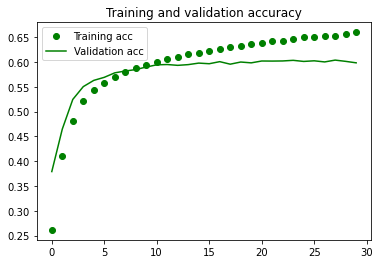

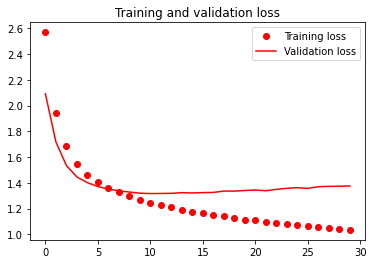

In [61]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
# Save the Model
model_lstm5.save('SeoShinYoun_LSTM5.h5')

## 1.6 - Final Stacked LSTM Model (Introduce Regularization + Higher Dropout)

In [67]:
model_lstm6 = keras.models.Sequential()
model_lstm6.add(layers.LSTM(256, input_shape=(maxlen, len(chars)), return_sequences=True, 
                            kernel_regularizer=l2(0.00002),recurrent_regularizer=l2(0.000005)))
model_lstm6.add(layers.Dropout(0.3))
model_lstm6.add(layers.LSTM(256, return_sequences=True, kernel_regularizer=l2(0.000005),
                                                       recurrent_regularizer=l2(0.000005)))
model_lstm6.add(layers.Dropout(0.3))
model_lstm6.add(layers.LSTM(256, return_sequences=True, kernel_regularizer=l2(0.000005),
                                                       recurrent_regularizer=l2(0.000005)))
model_lstm6.add(layers.Dropout(0.3))
model_lstm6.add(layers.LSTM(256, return_sequences=False, kernel_regularizer=l2(0.000005),
                                                       recurrent_regularizer=l2(0.000005)))
model_lstm6.add(layers.Dropout(0.3))
model_lstm6.add(layers.Dense(256, activation='relu'))
model_lstm6.add(layers.Dropout(0.3))
model_lstm6.add(layers.Dense(len(chars), activation='softmax'))
print(model_lstm6.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 35, 256)           290816    
                                                                 
 dropout_41 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_38 (LSTM)              (None, 35, 256)           525312    
                                                                 
 dropout_42 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_39 (LSTM)              (None, 35, 256)           525312    
                                                                 
 dropout_43 (Dropout)        (None, 35, 256)           0         
                                                                 
 lstm_40 (LSTM)              (None, 256)             

In [68]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_lstm6.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [69]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_lstm6.fit(x, y, batch_size=64, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
1760/1760 [==============================] - 64s 32ms/step - loss: 2.6411 - accuracy: 0.2474 - val_loss: 2.1952 - val_accuracy: 0.3588
Epoch 2/30
1760/1760 [==============================] - 56s 32ms/step - loss: 2.1005 - accuracy: 0.3803 - val_loss: 1.9022 - val_accuracy: 0.4323
Epoch 3/30
1760/1760 [==============================] - 57s 32ms/step - loss: 1.8855 - accuracy: 0.4389 - val_loss: 1.7154 - val_accuracy: 0.4922
Epoch 4/30
1760/1760 [==============================] - 56s 32ms/step - loss: 1.7549 - accuracy: 0.4804 - val_loss: 1.6058 - val_accuracy: 0.5202
Epoch 5/30
1760/1760 [==============================] - 57s 32ms/step - loss: 1.6714 - accuracy: 0.5047 - val_loss: 1.5562 - val_accuracy: 0.5364
Epoch 6/30
1760/1760 [==============================] - 56s 32ms/step - loss: 1.6197 - accuracy: 0.5217 - val_loss: 1.5208 - val_accuracy: 0.5500
Epoch 7/30
1760/1760 [==============================] - 56s 32ms/step - loss: 1.5799 - accuracy: 0.5338 - val_loss: 1.4929 -

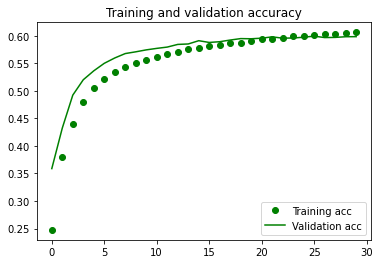

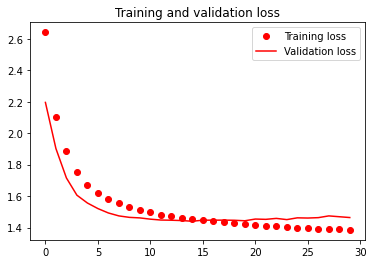

In [70]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_lstm6.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "the wind professor its about the so"
------ temperature: 0.1
the wind professor its about the sorcerers stone he be start to start to the stand and the stand and the stone that be a baby and they be a hand and the stand and the stand and the table the stone be not to the stand and the stand of the storm and the stand and the stone be a stand and the stand of the stand of the stone and the corridor the stand of the stand and the stone and the stand and the stand and the stand and the stand of
------ temperature: 0.3
the wind professor its about the sorcerers stone be not harry he say they have have be a start and the stand the stand and start at the door and have they be a still cloak into the way hagrid have take a bottle but they could not think i be the table of the granger be not a second and the stand and the house but the bloody of me one ron some though harry be ron be the mother and be the stand and harry think i be the stand of the ca
------ temperatu

In [71]:
# Save the Model
model_lstm6.save('SeoShinYoun_LSTM6.h5')

## 2.1 - Basic Bidirectional LSTM Model

In [74]:
model_bidirectional_LSTM = keras.models.Sequential()
model_bidirectional_LSTM.add(Bidirectional(LSTM(64, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM.add(Bidirectional(LSTM(64, return_sequences= True)))
model_bidirectional_LSTM.add(Bidirectional(LSTM(64, return_sequences= False)))
model_bidirectional_LSTM.add(layers.Dense(128, activation='relu'))
model_bidirectional_LSTM.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 35, 128)          47104     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 27)                3483      
                                                     

In [76]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_LSTM.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [77]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 37s 31ms/step - loss: 2.4398 - accuracy: 0.2976 - val_loss: 2.1566 - val_accuracy: 0.3570
Epoch 2/30
880/880 [==============================] - 26s 30ms/step - loss: 2.0070 - accuracy: 0.4011 - val_loss: 1.8951 - val_accuracy: 0.4269
Epoch 3/30
880/880 [==============================] - 27s 31ms/step - loss: 1.8503 - accuracy: 0.4410 - val_loss: 1.7639 - val_accuracy: 0.4651
Epoch 4/30
880/880 [==============================] - 30s 34ms/step - loss: 1.7121 - accuracy: 0.4774 - val_loss: 1.6428 - val_accuracy: 0.4954
Epoch 5/30
880/880 [==============================] - 29s 33ms/step - loss: 1.6171 - accuracy: 0.5025 - val_loss: 1.5876 - val_accuracy: 0.5091
Epoch 6/30
880/880 [==============================] - 34s 38ms/step - loss: 1.5504 - accuracy: 0.5212 - val_loss: 1.5413 - val_accuracy: 0.5238
Epoch 7/30
880/880 [==============================] - 30s 34ms/step - loss: 1.4973 - accuracy: 0.5351 - val_loss: 1.5033 - val_accuracy:

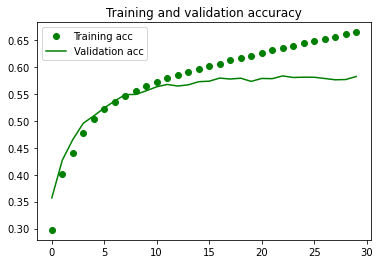

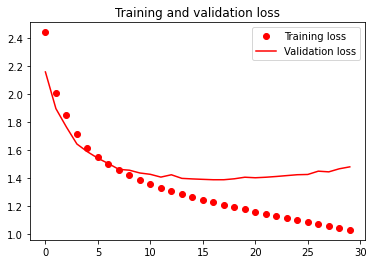

In [78]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_bidirectional_LSTM.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "ut wish he would be a bite quicker "
------ temperature: 0.1
ut wish he would be a bite quicker be something that be not they be not they be not they be not go to be something that be not they be not they have not see him they have not see him they have not see him harry have never happen the street the stand and seamus he say hagrid say harry have get the cloak and then she be a lot to see him he say and saw he be not the second he say hagrid say harry have get the stand the stone when he s
------ temperature: 0.3
ut wish he would be a bite quicker to the train of the lead hagrid say harry move and say harry the street the black the lead in the cloak first the letter the corner they be not they do not know the strange they stand a second but they be not go to be go to be over the train be read the stand back magic harry say the strange which be the stone be the door and say hagrid have never see harry and hermione they will not go to me and 
------ temperatu

In [80]:
# Save the Model
model_bidirectional_LSTM.save('SeoShinYoun_BidirectLSTM1.h5')

## 2.2 - Improved Bidirectional LSTM Model (Add Dropout = 0.2 for Overfitting Issue)

In [83]:
model_bidirectional_LSTM2 = keras.models.Sequential()
model_bidirectional_LSTM2.add(Bidirectional(LSTM(64, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM2.add(layers.Dropout(0.2))

model_bidirectional_LSTM2.add(Bidirectional(LSTM(64, return_sequences= True)))
model_bidirectional_LSTM2.add(layers.Dropout(0.2))

model_bidirectional_LSTM2.add(Bidirectional(LSTM(64, return_sequences= False)))
model_bidirectional_LSTM2.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM2.add(layers.Dense(128, activation='relu'))
model_bidirectional_LSTM2.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM2.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM2.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 35, 128)          47104     
 nal)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 35, 128)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 35, 128)          98816     
 nal)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 35, 128)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                     

In [84]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_LSTM2.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [85]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM2.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 40s 34ms/step - loss: 2.5025 - accuracy: 0.2837 - val_loss: 2.1993 - val_accuracy: 0.3580
Epoch 2/30
880/880 [==============================] - 29s 33ms/step - loss: 2.1435 - accuracy: 0.3644 - val_loss: 2.0055 - val_accuracy: 0.4001
Epoch 3/30
880/880 [==============================] - 30s 34ms/step - loss: 1.9847 - accuracy: 0.4069 - val_loss: 1.8355 - val_accuracy: 0.4443
Epoch 4/30
880/880 [==============================] - 30s 34ms/step - loss: 1.8721 - accuracy: 0.4353 - val_loss: 1.7350 - val_accuracy: 0.4677
Epoch 5/30
880/880 [==============================] - 31s 35ms/step - loss: 1.7987 - accuracy: 0.4535 - val_loss: 1.6759 - val_accuracy: 0.4845
Epoch 6/30
880/880 [==============================] - 31s 35ms/step - loss: 1.7431 - accuracy: 0.4688 - val_loss: 1.6216 - val_accuracy: 0.5036
Epoch 7/30
880/880 [==============================] - 32s 36ms/step - loss: 1.6981 - accuracy: 0.4811 - val_loss: 1.5840 - val_accuracy:

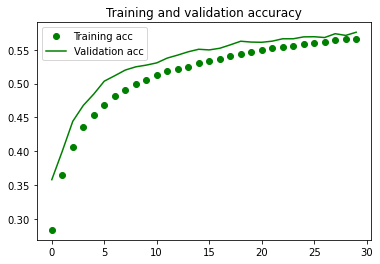

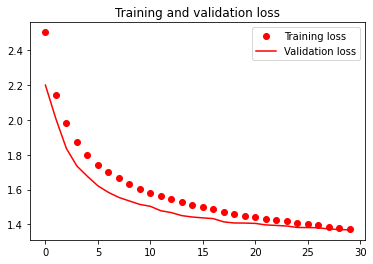

In [86]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:
# Save the Model
model_bidirectional_LSTM2.save('SeoShinYoun_BidirectLSTM2.h5')

## 2.3 - Improved Bidirectional LSTM Model (Increase Units to tackle Underfitting)

In [96]:
model_bidirectional_LSTM3 = keras.models.Sequential()
model_bidirectional_LSTM3.add(Bidirectional(LSTM(128, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM3.add(layers.Dropout(0.2))

model_bidirectional_LSTM3.add(Bidirectional(LSTM(128, return_sequences= True)))
model_bidirectional_LSTM3.add(layers.Dropout(0.2))

model_bidirectional_LSTM3.add(Bidirectional(LSTM(64, return_sequences= False)))
model_bidirectional_LSTM3.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM3.add(layers.Dense(256, activation='relu'))
model_bidirectional_LSTM3.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM3.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM3.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 35, 256)          159744    
 onal)                                                           
                                                                 
 dropout_63 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 35, 256)          394240    
 onal)                                                           
                                                                 
 dropout_64 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                     

In [97]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_LSTM3.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [98]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM3.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15, 
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 47s 41ms/step - loss: 2.4008 - accuracy: 0.3076 - val_loss: 2.1284 - val_accuracy: 0.3627
Epoch 2/30
880/880 [==============================] - 37s 42ms/step - loss: 2.0393 - accuracy: 0.3912 - val_loss: 1.8648 - val_accuracy: 0.4368
Epoch 3/30
880/880 [==============================] - 40s 45ms/step - loss: 1.8610 - accuracy: 0.4401 - val_loss: 1.7289 - val_accuracy: 0.4693
Epoch 4/30
880/880 [==============================] - 40s 45ms/step - loss: 1.7491 - accuracy: 0.4685 - val_loss: 1.6264 - val_accuracy: 0.4978
Epoch 5/30
880/880 [==============================] - 45s 51ms/step - loss: 1.6624 - accuracy: 0.4910 - val_loss: 1.5389 - val_accuracy: 0.5238
Epoch 6/30
880/880 [==============================] - 47s 53ms/step - loss: 1.5938 - accuracy: 0.5101 - val_loss: 1.4999 - val_accuracy: 0.5385
Epoch 7/30
880/880 [==============================] - 43s 49ms/step - loss: 1.5497 - accuracy: 0.5227 - val_loss: 1.4606 - val_accuracy:

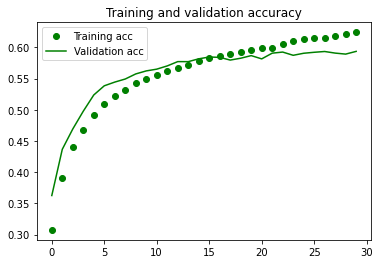

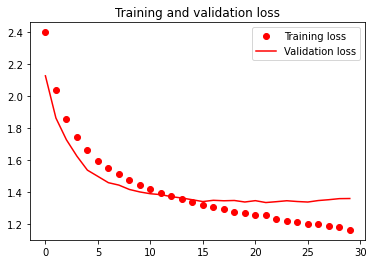

In [99]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [100]:
# Save the Model
model_bidirectional_LSTM3.save('SeoShinYoun_BidirectLSTM3.h5')

## 2.4 - Improved Bidirectional LSTM Model (Increase Units + Layers to Increase Accuracy)

In [91]:
model_bidirectional_LSTM4 = keras.models.Sequential()
model_bidirectional_LSTM4.add(Bidirectional(LSTM(256, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM4.add(layers.Dropout(0.2))

model_bidirectional_LSTM4.add(Bidirectional(LSTM(256, return_sequences= True)))
model_bidirectional_LSTM4.add(layers.Dropout(0.2))

model_bidirectional_LSTM4.add(Bidirectional(LSTM(128, return_sequences= True)))
model_bidirectional_LSTM4.add(layers.Dropout(0.2))

model_bidirectional_LSTM4.add(Bidirectional(LSTM(128, return_sequences= False)))
model_bidirectional_LSTM4.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM4.add(layers.Dense(256, activation='relu'))
model_bidirectional_LSTM4.add(layers.Dropout(0.2))
                
model_bidirectional_LSTM4.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM4.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 35, 512)          581632    
 onal)                                                           
                                                                 
 dropout_58 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 35, 512)          1574912   
 onal)                                                           
                                                                 
 dropout_59 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 35, 256)          656384    
 onal)                                                           
                                                     

In [92]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_LSTM4.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [93]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM4.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 92s 88ms/step - loss: 2.4130 - accuracy: 0.3041 - val_loss: 2.1300 - val_accuracy: 0.3615
Epoch 2/30
880/880 [==============================] - 77s 87ms/step - loss: 2.0174 - accuracy: 0.3979 - val_loss: 1.8470 - val_accuracy: 0.4363
Epoch 3/30
880/880 [==============================] - 81s 92ms/step - loss: 1.8282 - accuracy: 0.4456 - val_loss: 1.7058 - val_accuracy: 0.4756
Epoch 4/30
880/880 [==============================] - 82s 93ms/step - loss: 1.7157 - accuracy: 0.4746 - val_loss: 1.6068 - val_accuracy: 0.5001
Epoch 5/30
880/880 [==============================] - 81s 92ms/step - loss: 1.6290 - accuracy: 0.4965 - val_loss: 1.5254 - val_accuracy: 0.5233
Epoch 6/30
880/880 [==============================] - 81s 93ms/step - loss: 1.5616 - accuracy: 0.5152 - val_loss: 1.4866 - val_accuracy: 0.5357
Epoch 7/30
880/880 [==============================] - 82s 93ms/step - loss: 1.5050 - accuracy: 0.5315 - val_loss: 1.4506 - val_accuracy:

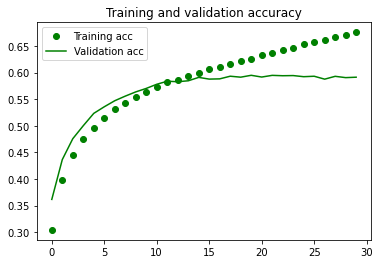

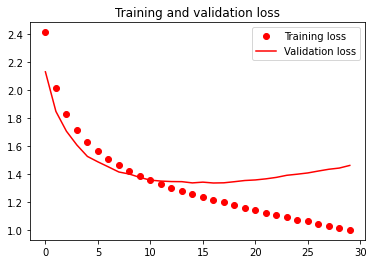

In [94]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [95]:
# Save the Model
model_bidirectional_LSTM4.save('SeoShinYoun_BidirectLSTM4.h5')

## 2.5 - Improved Bidirectional LSTM Model (Regularization + Dropout + Decrease Batch Size)

In [108]:
model_bidirectional_LSTM5 = keras.models.Sequential()
model_bidirectional_LSTM5.add(Bidirectional(LSTM(256, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM5.add(layers.Dropout(0.3))
model_bidirectional_LSTM5.add(Bidirectional(LSTM(256, return_sequences= True,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM5.add(layers.Dropout(0.3))
model_bidirectional_LSTM5.add(Bidirectional(LSTM(128, return_sequences= True,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM5.add(layers.Dropout(0.3))
model_bidirectional_LSTM5.add(Bidirectional(LSTM(128, return_sequences= False,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM5.add(layers.Dropout(0.3))
model_bidirectional_LSTM5.add(layers.Dense(256, activation='relu'))
model_bidirectional_LSTM5.add(layers.Dropout(0.3))    
model_bidirectional_LSTM5.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM5.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_23 (Bidirecti  (None, 35, 512)          581632    
 onal)                                                           
                                                                 
 dropout_72 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 35, 512)          1574912   
 onal)                                                           
                                                                 
 dropout_73 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 35, 256)          656384    
 onal)                                                           
                                                     

In [106]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_LSTM5.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [107]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM5.fit(x, y, batch_size=64, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
1760/1760 [==============================] - 103s 52ms/step - loss: 2.4522 - accuracy: 0.3038 - val_loss: 2.1693 - val_accuracy: 0.3580
Epoch 2/30
1760/1760 [==============================] - 95s 54ms/step - loss: 2.1104 - accuracy: 0.3842 - val_loss: 1.9782 - val_accuracy: 0.4097
Epoch 3/30
1760/1760 [==============================] - 102s 58ms/step - loss: 1.9625 - accuracy: 0.4246 - val_loss: 1.8302 - val_accuracy: 0.4500
Epoch 4/30
1760/1760 [==============================] - 107s 61ms/step - loss: 1.8636 - accuracy: 0.4517 - val_loss: 1.7433 - val_accuracy: 0.4787
Epoch 5/30
1760/1760 [==============================] - 109s 62ms/step - loss: 1.8006 - accuracy: 0.4699 - val_loss: 1.6872 - val_accuracy: 0.4983
Epoch 6/30
1760/1760 [==============================] - 112s 63ms/step - loss: 1.7489 - accuracy: 0.4850 - val_loss: 1.6454 - val_accuracy: 0.5097
Epoch 7/30
1760/1760 [==============================] - 114s 65ms/step - loss: 1.7127 - accuracy: 0.4962 - val_loss: 1.

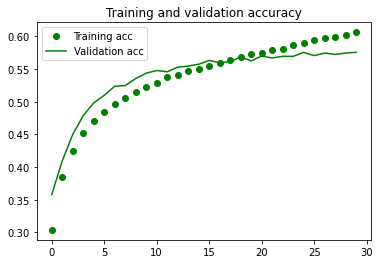

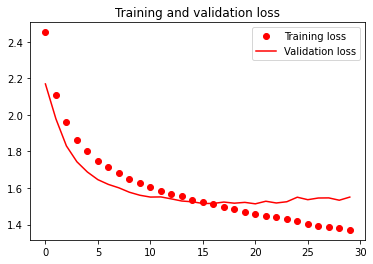

In [109]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [111]:
# Save the Model
model_bidirectional_LSTM5.save('SeoShinYoun_BidirectLSTM5.h5')

## 2.6 - Final Bidirectional LSTM Model (Increase Dropout + Learning Rate)

In [112]:
model_bidirectional_LSTM6 = keras.models.Sequential()
model_bidirectional_LSTM6.add(Bidirectional(LSTM(256, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_LSTM6.add(layers.Dropout(0.38))

model_bidirectional_LSTM6.add(Bidirectional(LSTM(256, return_sequences= True,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM6.add(layers.Dropout(0.38))

model_bidirectional_LSTM6.add(Bidirectional(LSTM(128, return_sequences= True,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM6.add(layers.Dropout(0.38))

model_bidirectional_LSTM6.add(Bidirectional(LSTM(128, return_sequences= False,
                                                 kernel_regularizer=l2(0.00002),
                                                 recurrent_regularizer=l2(0.000005))))
model_bidirectional_LSTM6.add(layers.Dropout(0.38))
                
model_bidirectional_LSTM6.add(layers.Dense(256, activation='relu'))
model_bidirectional_LSTM6.add(layers.Dropout(0.38))
                
model_bidirectional_LSTM6.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_LSTM6.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_27 (Bidirecti  (None, 35, 512)          581632    
 onal)                                                           
                                                                 
 dropout_77 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 35, 512)          1574912   
 onal)                                                           
                                                                 
 dropout_78 (Dropout)        (None, 35, 512)           0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 35, 256)          656384    
 onal)                                                           
                                                     

In [114]:
optimizer = optimizers.Adam(learning_rate = 0.002)
model_bidirectional_LSTM6.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [115]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_LSTM6.fit(x, y, batch_size=64, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
1760/1760 [==============================] - 100s 50ms/step - loss: 2.4340 - accuracy: 0.3064 - val_loss: 2.0816 - val_accuracy: 0.4009
Epoch 2/30
1760/1760 [==============================] - 90s 51ms/step - loss: 2.0784 - accuracy: 0.4076 - val_loss: 1.9007 - val_accuracy: 0.4479
Epoch 3/30
1760/1760 [==============================] - 95s 54ms/step - loss: 1.9671 - accuracy: 0.4425 - val_loss: 1.8145 - val_accuracy: 0.4777
Epoch 4/30
1760/1760 [==============================] - 98s 56ms/step - loss: 1.8936 - accuracy: 0.4656 - val_loss: 1.7638 - val_accuracy: 0.4940
Epoch 5/30
1760/1760 [==============================] - 102s 58ms/step - loss: 1.8458 - accuracy: 0.4805 - val_loss: 1.7347 - val_accuracy: 0.5023
Epoch 6/30
1760/1760 [==============================] - 108s 61ms/step - loss: 1.8080 - accuracy: 0.4913 - val_loss: 1.6912 - val_accuracy: 0.5186
Epoch 7/30
1760/1760 [==============================] - 101s 57ms/step - loss: 1.7751 - accuracy: 0.4998 - val_loss: 1.67

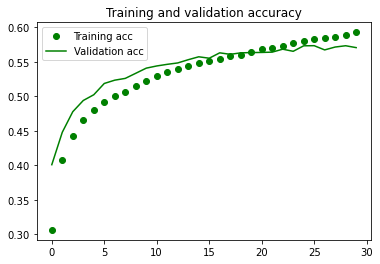

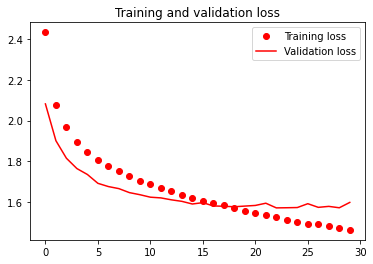

In [116]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [117]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_bidirectional_LSTM6.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "oe toward the trophy room malfoy an"
------ temperature: 0.1
oe toward the trophy room malfoy and harry be say the corridor the boy he be that be the back to be and they be have to harry they be be that be the back to be that they so they be come that be be that they be be be be say the back to the boy they be be be harry that and and be and they be be that be the star the back to the back to the boy the stand the that they be be be harry then the boy the corridor they be be be be be that be
------ temperature: 0.3
oe toward the trophy room malfoy and a slatter the back to the car they be the corridor that no one have stop that they have head the boy but be him and a state the forest that look that be he be harry and the back to his hand and have be be her be the sand to him the corridor say and the mard and they think they would be say and they start be the could harry which not have potter should be and the door in the head a train thine of
------ temperatu

In [118]:
# Save the Model
model_bidirectional_LSTM6.save('SeoShinYoun_BidirectLSTM6.h5')

## 3.1 - Basic Bidirectional GRU Model

In [119]:
#Bidirectional GRU
model_bidirectional_GRU = keras.models.Sequential()
model_bidirectional_GRU.add(Bidirectional(GRU(64, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_GRU.add(Bidirectional(GRU(64, return_sequences= True)))
model_bidirectional_GRU.add(Bidirectional(GRU(64, return_sequences= False)))
model_bidirectional_GRU.add(layers.Dense(128, activation='relu'))
model_bidirectional_GRU.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_GRU.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 35, 128)          35712     
 onal)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 35, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 128)              74496     
 onal)                                                           
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dense_40 (Dense)            (None, 27)                3483      
                                                     

In [120]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_GRU.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [121]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_GRU.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 35s 30ms/step - loss: 2.1478 - accuracy: 0.3684 - val_loss: 1.8558 - val_accuracy: 0.4349
Epoch 2/30
880/880 [==============================] - 23s 26ms/step - loss: 1.7499 - accuracy: 0.4675 - val_loss: 1.6666 - val_accuracy: 0.4925
Epoch 3/30
880/880 [==============================] - 23s 27ms/step - loss: 1.6002 - accuracy: 0.5085 - val_loss: 1.5575 - val_accuracy: 0.5213
Epoch 4/30
880/880 [==============================] - 24s 27ms/step - loss: 1.5076 - accuracy: 0.5328 - val_loss: 1.4978 - val_accuracy: 0.5399
Epoch 5/30
880/880 [==============================] - 24s 28ms/step - loss: 1.4403 - accuracy: 0.5522 - val_loss: 1.4640 - val_accuracy: 0.5491
Epoch 6/30
880/880 [==============================] - 25s 28ms/step - loss: 1.3842 - accuracy: 0.5666 - val_loss: 1.4375 - val_accuracy: 0.5590
Epoch 7/30
880/880 [==============================] - 25s 29ms/step - loss: 1.3357 - accuracy: 0.5802 - val_loss: 1.4313 - val_accuracy:

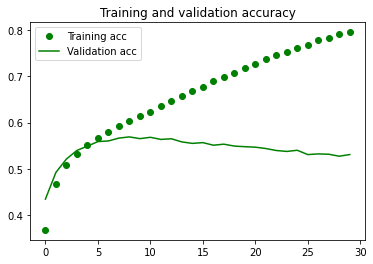

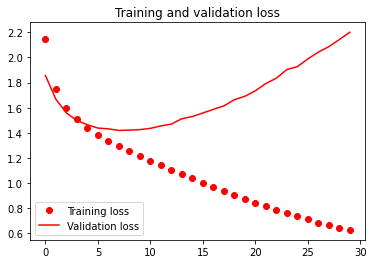

In [122]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [123]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_bidirectional_GRU.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "stle a troll harry smile weakly yes"
------ temperature: 0.1
stle a troll harry smile weakly yes in the hall sock overcous that be all over himself too good all them to hundly wide have be beard a few what he a say harry and hagrid sure the nostest then be a giar something to the snake say ron harry have tell him the seeker he be suppose to scream say the dursleys say the house harry and the marceres stone every madam the small he be to his be our drive his head a sad hermione street but the
------ temperature: 0.3
stle a troll harry smile weakly yes in the recorl students back and the hear him and the time the dursleys how straight a wizard to know he think about the fire the fire for the middle go to star of the cheer on the room and gat off the boat and look at harry to catch the hall have see they have not he say slowly to him first yet the back of the gryffindor sky him he have you hagrid ead you screa of his she wiff of harry have get t
------ temperatu

In [124]:
# Save the Model
model_bidirectional_GRU.save('SeoShinYoun_BidirectGRU.h5')

## 3.2 Improved Bidirectional GRU Model (Add Dropout = 0.2 for Overfitting Issue)

In [125]:
#Bidirectional GRU
model_bidirectional_GRU2 = keras.models.Sequential()
model_bidirectional_GRU2.add(Bidirectional(GRU(64, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_GRU2.add(layers.Dropout(0.2))

model_bidirectional_GRU2.add(Bidirectional(GRU(64, return_sequences= True)))
model_bidirectional_GRU2.add(layers.Dropout(0.2))

model_bidirectional_GRU2.add(Bidirectional(GRU(64, return_sequences= False)))
model_bidirectional_GRU2.add(layers.Dropout(0.2))

model_bidirectional_GRU2.add(layers.Dense(128, activation='relu'))
model_bidirectional_GRU2.add(layers.Dropout(0.2))

model_bidirectional_GRU2.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_GRU2.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_34 (Bidirecti  (None, 35, 128)          35712     
 onal)                                                           
                                                                 
 dropout_82 (Dropout)        (None, 35, 128)           0         
                                                                 
 bidirectional_35 (Bidirecti  (None, 35, 128)          74496     
 onal)                                                           
                                                                 
 dropout_83 (Dropout)        (None, 35, 128)           0         
                                                                 
 bidirectional_36 (Bidirecti  (None, 128)              74496     
 onal)                                                           
                                                     

In [126]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_GRU2.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [127]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_GRU2.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 38s 30ms/step - loss: 2.2896 - accuracy: 0.3356 - val_loss: 1.9574 - val_accuracy: 0.4134
Epoch 2/30
880/880 [==============================] - 25s 28ms/step - loss: 1.9479 - accuracy: 0.4185 - val_loss: 1.7625 - val_accuracy: 0.4564
Epoch 3/30
880/880 [==============================] - 24s 27ms/step - loss: 1.8234 - accuracy: 0.4492 - val_loss: 1.6737 - val_accuracy: 0.4842
Epoch 4/30
880/880 [==============================] - 26s 29ms/step - loss: 1.7503 - accuracy: 0.4677 - val_loss: 1.6072 - val_accuracy: 0.5036
Epoch 5/30
880/880 [==============================] - 27s 30ms/step - loss: 1.6953 - accuracy: 0.4825 - val_loss: 1.5571 - val_accuracy: 0.5171
Epoch 6/30
880/880 [==============================] - 28s 32ms/step - loss: 1.6575 - accuracy: 0.4919 - val_loss: 1.5291 - val_accuracy: 0.5263
Epoch 7/30
880/880 [==============================] - 28s 31ms/step - loss: 1.6227 - accuracy: 0.5019 - val_loss: 1.5074 - val_accuracy:

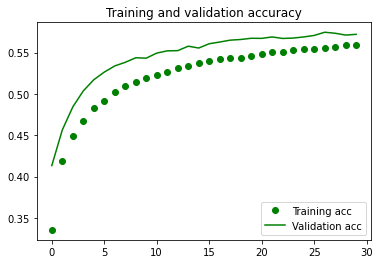

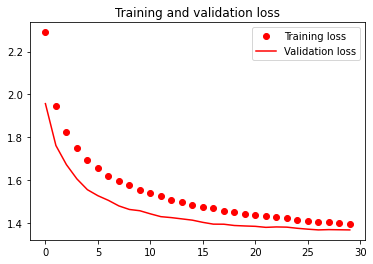

In [128]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [129]:
# Save the Model
model_bidirectional_GRU2.save('SeoShinYoun_BidirectGRU2.h5')

## 3.3 Improved Bidirectional GRU Model (Increase Units to Tackle Underfitting)

In [130]:
#Bidirectional GRU
model_bidirectional_GRU3 = keras.models.Sequential()
model_bidirectional_GRU3.add(Bidirectional(GRU(128, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_GRU3.add(layers.Dropout(0.2))

model_bidirectional_GRU3.add(Bidirectional(GRU(128, return_sequences= True)))
model_bidirectional_GRU3.add(layers.Dropout(0.2))

model_bidirectional_GRU3.add(Bidirectional(GRU(64, return_sequences= False)))
model_bidirectional_GRU3.add(layers.Dropout(0.2))

model_bidirectional_GRU3.add(layers.Dense(512, activation='relu'))
model_bidirectional_GRU3.add(layers.Dropout(0.2))

model_bidirectional_GRU3.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_GRU3.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_37 (Bidirecti  (None, 35, 256)          120576    
 onal)                                                           
                                                                 
 dropout_86 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_38 (Bidirecti  (None, 35, 256)          296448    
 onal)                                                           
                                                                 
 dropout_87 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                     

In [131]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_GRU3.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [132]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_GRU3.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15, 
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 37s 32ms/step - loss: 2.1560 - accuracy: 0.3644 - val_loss: 1.8186 - val_accuracy: 0.4451
Epoch 2/30
880/880 [==============================] - 28s 32ms/step - loss: 1.8029 - accuracy: 0.4518 - val_loss: 1.6241 - val_accuracy: 0.4971
Epoch 3/30
880/880 [==============================] - 28s 32ms/step - loss: 1.6712 - accuracy: 0.4878 - val_loss: 1.5490 - val_accuracy: 0.5210
Epoch 4/30
880/880 [==============================] - 28s 32ms/step - loss: 1.5926 - accuracy: 0.5088 - val_loss: 1.4951 - val_accuracy: 0.5334
Epoch 5/30
880/880 [==============================] - 29s 33ms/step - loss: 1.5361 - accuracy: 0.5245 - val_loss: 1.4451 - val_accuracy: 0.5537
Epoch 6/30
880/880 [==============================] - 30s 34ms/step - loss: 1.4932 - accuracy: 0.5363 - val_loss: 1.4198 - val_accuracy: 0.5560
Epoch 7/30
880/880 [==============================] - 33s 38ms/step - loss: 1.4585 - accuracy: 0.5459 - val_loss: 1.3949 - val_accuracy:

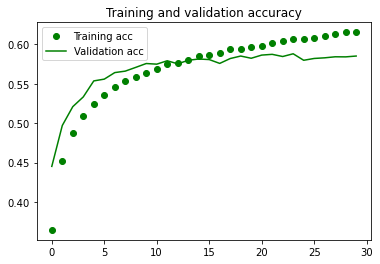

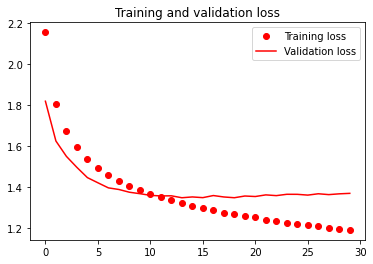

In [133]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [134]:
# Save the Model
model_bidirectional_GRU3.save('SeoShinYoun_BidirectGRU3.h5')

## 3.4 Improved Bidirectional GRU Model (Add Regularization To Reduce Overfitting)

In [135]:
#Bidirectional GRU
model_bidirectional_GRU4 = keras.models.Sequential()
model_bidirectional_GRU4.add(Bidirectional(GRU(128, return_sequences = True),input_shape=(maxlen, len(chars))))
model_bidirectional_GRU4.add(layers.Dropout(0.2))

model_bidirectional_GRU4.add(Bidirectional(GRU(128, return_sequences= True,
                                              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))))
model_bidirectional_GRU4.add(layers.Dropout(0.2))

model_bidirectional_GRU4.add(Bidirectional(GRU(64, return_sequences= False, 
                                              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))))
model_bidirectional_GRU4.add(layers.Dropout(0.2))

model_bidirectional_GRU4.add(layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.00005)))
model_bidirectional_GRU4.add(layers.Dropout(0.2))

model_bidirectional_GRU4.add(layers.Dense(len(chars), activation='softmax', kernel_regularizer = regularizers.l2(0.00005)))
print(model_bidirectional_GRU4.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_40 (Bidirecti  (None, 35, 256)          120576    
 onal)                                                           
                                                                 
 dropout_90 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_41 (Bidirecti  (None, 35, 256)          296448    
 onal)                                                           
                                                                 
 dropout_91 (Dropout)        (None, 35, 256)           0         
                                                                 
 bidirectional_42 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                     

In [136]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_bidirectional_GRU4.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [137]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_GRU4.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15, 
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 42s 35ms/step - loss: 2.4841 - accuracy: 0.3295 - val_loss: 2.1315 - val_accuracy: 0.3870
Epoch 2/30
880/880 [==============================] - 29s 33ms/step - loss: 2.0809 - accuracy: 0.3999 - val_loss: 1.9557 - val_accuracy: 0.4302
Epoch 3/30
880/880 [==============================] - 31s 35ms/step - loss: 1.9699 - accuracy: 0.4302 - val_loss: 1.8623 - val_accuracy: 0.4561
Epoch 4/30
880/880 [==============================] - 32s 37ms/step - loss: 1.9098 - accuracy: 0.4482 - val_loss: 1.8167 - val_accuracy: 0.4687
Epoch 5/30
880/880 [==============================] - 34s 39ms/step - loss: 1.8534 - accuracy: 0.4628 - val_loss: 1.7571 - val_accuracy: 0.4806
Epoch 6/30
880/880 [==============================] - 35s 40ms/step - loss: 1.8108 - accuracy: 0.4746 - val_loss: 1.7248 - val_accuracy: 0.4963
Epoch 7/30
880/880 [==============================] - 36s 41ms/step - loss: 1.7794 - accuracy: 0.4832 - val_loss: 1.6849 - val_accuracy:

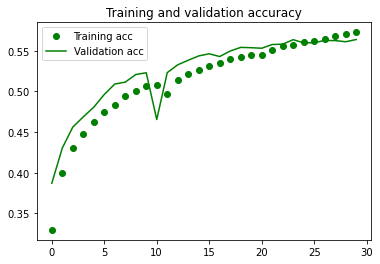

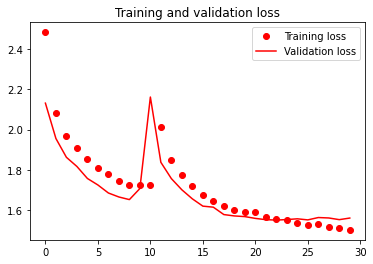

In [138]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [139]:
# Save the Model
model_bidirectional_GRU4.save('SeoShinYoun_BidirectGRU4.h5')

## 3.5 Final Bidirectional GRU Model (Increase Units Per Layer + Add Dense Layer)

In [147]:
#Bidirectional GRU
model_bidirectional_GRU5 = keras.models.Sequential()
model_bidirectional_GRU5.add(Bidirectional(GRU(256, return_sequences = True,
                                                       kernel_regularizer=l2(0.00002),
                                                       recurrent_regularizer=l2(0.00002)),
                                                   input_shape=(maxlen, len(chars))))
model_bidirectional_GRU5.add(layers.Dropout(0.2))
model_bidirectional_GRU5.add(Bidirectional(GRU(128, return_sequences = True,
                                                       kernel_regularizer=l2(0.00002),
                                                       recurrent_regularizer=l2(0.00002))))
model_bidirectional_GRU5.add(layers.Dropout(0.2))
model_bidirectional_GRU5.add(Bidirectional(GRU(128, return_sequences=False,
                                                      kernel_regularizer=l2(0.00002),
                                                       recurrent_regularizer=l2(0.00002))))
model_bidirectional_GRU5.add(layers.Dropout(0.2))
model_bidirectional_GRU5.add(layers.Dense(512, activation='relu'))
model_bidirectional_GRU5.add(layers.Dropout(0.2))
model_bidirectional_GRU5.add(layers.Dense(128, activation='relu'))
model_bidirectional_GRU5.add(layers.Dropout(0.2))
model_bidirectional_GRU5.add(layers.Dense(len(chars), activation='softmax'))
print(model_bidirectional_GRU5.summary())

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_49 (Bidirecti  (None, 35, 512)          437760    
 onal)                                                           
                                                                 
 dropout_102 (Dropout)       (None, 35, 512)           0         
                                                                 
 bidirectional_50 (Bidirecti  (None, 35, 256)          493056    
 onal)                                                           
                                                                 
 dropout_103 (Dropout)       (None, 35, 256)           0         
                                                                 
 bidirectional_51 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                     

In [148]:
optimizer = optimizers.Adam(learning_rate = 0.0005)
model_bidirectional_GRU5.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [149]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 6)
history = model_bidirectional_GRU5.fit(x, y, batch_size=128, epochs=30,
                         validation_split=0.15, 
                         callbacks = [earlystopping])

Epoch 1/30
880/880 [==============================] - 55s 49ms/step - loss: 2.3195 - accuracy: 0.3333 - val_loss: 2.0109 - val_accuracy: 0.4037
Epoch 2/30
880/880 [==============================] - 42s 47ms/step - loss: 1.9807 - accuracy: 0.4170 - val_loss: 1.8106 - val_accuracy: 0.4544
Epoch 3/30
880/880 [==============================] - 42s 48ms/step - loss: 1.8470 - accuracy: 0.4523 - val_loss: 1.6969 - val_accuracy: 0.4858
Epoch 4/30
880/880 [==============================] - 42s 47ms/step - loss: 1.7665 - accuracy: 0.4737 - val_loss: 1.6446 - val_accuracy: 0.5066
Epoch 5/30
880/880 [==============================] - 43s 49ms/step - loss: 1.7134 - accuracy: 0.4880 - val_loss: 1.5944 - val_accuracy: 0.5193
Epoch 6/30
880/880 [==============================] - 44s 50ms/step - loss: 1.6711 - accuracy: 0.5001 - val_loss: 1.5637 - val_accuracy: 0.5288
Epoch 7/30
880/880 [==============================] - 44s 50ms/step - loss: 1.6363 - accuracy: 0.5096 - val_loss: 1.5344 - val_accuracy:

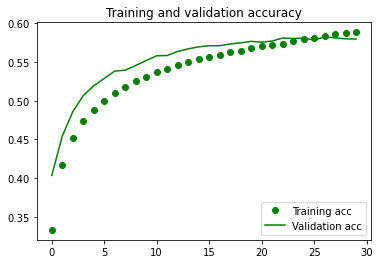

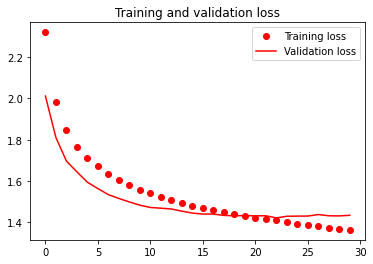

In [150]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [151]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_bidirectional_GRU5.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "ack knight and put his hand out to "
------ temperature: 0.1
ack knight and put his hand out to the strain he be the star and the stand and the stand the stand the stand the stand the stand the stand the stand the stand a start to the stand the stand the staircase the stone and the stand the stand the stand the stand the strain the staircase the stand the stand the stand a should not be a take the star the star at the staircase the stand and the stand the staircase the start to the stand the
------ temperature: 0.3
ack knight and put his hand out to a bite a second he be something hagrid s be with the staircal he see and the broom the boys the stop the train have not be the table the black and the first the second and the the the stone and the corner and the way in the think the want to the set and the that be something the barry and the shat hagrid could not the stand and percy do not see something they have be harry see the look with his tr
------ temperatu

In [152]:
# Save the Model
model_bidirectional_GRU5.save('SeoShinYoun_BidirectGRU5.h5')

## 4.1 - SimpleRNN Model

In [155]:
model_simpleRNN = keras.models.Sequential()

model_simpleRNN.add(SimpleRNN(32, return_sequences = True,input_shape=(maxlen, len(chars))))

model_simpleRNN.add(SimpleRNN(32, return_sequences = True))

model_simpleRNN.add(SimpleRNN(32, return_sequences = False))

model_simpleRNN.add(layers.Dense(250, activation='relu'))
model_simpleRNN.add(layers.Dense(len(chars), activation='softmax'))
model_simpleRNN.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 35, 32)            1920      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 35, 32)            2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 250)               8250      
                                                                 
 dense_57 (Dense)            (None, 27)                6777      
                                                                 
Total params: 21,107
Trainable params: 21,107
Non-trainable params: 0
_________________________________________________________________


In [156]:
optimizer = optimizers.Adam()
model_simpleRNN.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [158]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 10)
history = model_simpleRNN.fit(x, y, batch_size=512, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
220/220 [==============================] - 27s 120ms/step - loss: 2.1943 - accuracy: 0.3541 - val_loss: 2.0959 - val_accuracy: 0.3797
Epoch 2/30
220/220 [==============================] - 26s 118ms/step - loss: 2.0357 - accuracy: 0.3949 - val_loss: 1.9712 - val_accuracy: 0.4066
Epoch 3/30
220/220 [==============================] - 27s 121ms/step - loss: 1.9416 - accuracy: 0.4182 - val_loss: 1.9015 - val_accuracy: 0.4277
Epoch 4/30
220/220 [==============================] - 26s 119ms/step - loss: 1.8735 - accuracy: 0.4351 - val_loss: 1.8382 - val_accuracy: 0.4456
Epoch 5/30
220/220 [==============================] - 28s 127ms/step - loss: 1.8190 - accuracy: 0.4504 - val_loss: 1.7926 - val_accuracy: 0.4533
Epoch 6/30
220/220 [==============================] - 28s 127ms/step - loss: 1.7768 - accuracy: 0.4613 - val_loss: 1.7589 - val_accuracy: 0.4628
Epoch 7/30
220/220 [==============================] - 29s 131ms/step - loss: 1.7418 - accuracy: 0.4729 - val_loss: 1.7292 - val_ac

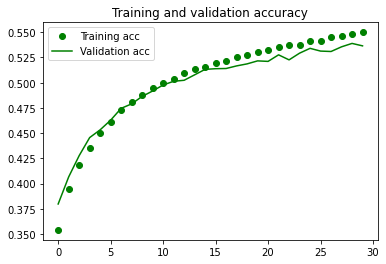

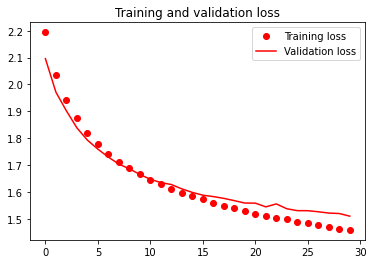

In [159]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [160]:
# Select a text seed at random
start_index = random.randint(0, len(text_string) - maxlen - 1)
generated_text_initial = text_string[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model_simpleRNN.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "er know very well what he and petun"
------ temperature: 0.1
er know very well what he and petunia think the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stind the stop the string on the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop the stop and the stop the stop the stop the stop the stop the stop the stop the string on the star of the stop the 
------ temperature: 0.3
er know very well what he and petunia things the corrid stone a stornot have not have some say harry so on the stairs and on the stop of the still on the stone the colles the store say harry say harry be while be say on the stand and the stone the stop of the star and the stop of the potter the way harry be the first he wand the the stop he say harry the corrid and the stritcheel the parch his be a things be the door the corrow be 
------ temperatu

In [161]:
# Save the Model
model_simpleRNN.save('SeoShinYoun_SimpleRNN.h5')

## 4.2 - Improved SimpleRNN Model (Increase Units + Add Dropout Layer)

In [162]:
model_simpleRNN2 = keras.models.Sequential()

model_simpleRNN2.add(SimpleRNN(64, return_sequences = True,input_shape=(maxlen, len(chars))))
model_simpleRNN2.add(layers.Dropout(0.1))

model_simpleRNN2.add(SimpleRNN(64, return_sequences = True))
model_simpleRNN2.add(layers.Dropout(0.1))

model_simpleRNN2.add(SimpleRNN(64, return_sequences = False))
model_simpleRNN2.add(layers.Dropout(0.1))

model_simpleRNN2.add(layers.Dense(250, activation='relu'))
model_simpleRNN2.add(layers.Dense(len(chars), activation='softmax'))
model_simpleRNN2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 35, 64)            5888      
                                                                 
 dropout_107 (Dropout)       (None, 35, 64)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 35, 64)            8256      
                                                                 
 dropout_108 (Dropout)       (None, 35, 64)            0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_109 (Dropout)       (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 250)             

In [163]:
optimizer = optimizers.Adam()
model_simpleRNN2.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [164]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 10)
history = model_simpleRNN2.fit(x, y, batch_size=512, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
220/220 [==============================] - 31s 128ms/step - loss: 2.5232 - accuracy: 0.2789 - val_loss: 2.1719 - val_accuracy: 0.3615
Epoch 2/30
220/220 [==============================] - 31s 139ms/step - loss: 2.1074 - accuracy: 0.3744 - val_loss: 1.9529 - val_accuracy: 0.4133
Epoch 3/30
220/220 [==============================] - 32s 144ms/step - loss: 1.9586 - accuracy: 0.4128 - val_loss: 1.8292 - val_accuracy: 0.4378
Epoch 4/30
220/220 [==============================] - 31s 140ms/step - loss: 1.8698 - accuracy: 0.4356 - val_loss: 1.7502 - val_accuracy: 0.4661
Epoch 5/30
220/220 [==============================] - 28s 129ms/step - loss: 1.8074 - accuracy: 0.4519 - val_loss: 1.7005 - val_accuracy: 0.4794
Epoch 6/30
220/220 [==============================] - 28s 127ms/step - loss: 1.7619 - accuracy: 0.4644 - val_loss: 1.6569 - val_accuracy: 0.4901
Epoch 7/30
220/220 [==============================] - 30s 135ms/step - loss: 1.7250 - accuracy: 0.4723 - val_loss: 1.6243 - val_ac

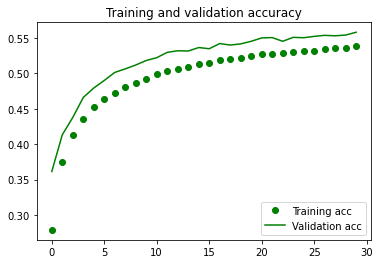

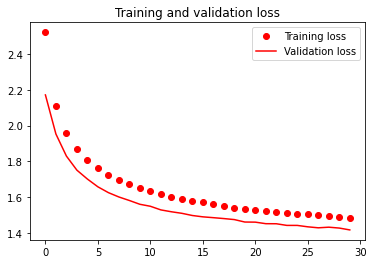

In [165]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [166]:
# Save the Model
model_simpleRNN2.save('SeoShinYoun_SimpleRNN2.h5')

## 4.3 - Final SimpleRNN Model (Increase Units + Add SimpleRNN Layers + Regularization)

In [175]:
model_simpleRNN3 = keras.models.Sequential()

model_simpleRNN3.add(SimpleRNN(128, return_sequences = True,input_shape=(maxlen, len(chars))))
model_simpleRNN3.add(layers.Dropout(0.1))

model_simpleRNN3.add(SimpleRNN(128, return_sequences = True))
model_simpleRNN3.add(layers.Dropout(0.1))

model_simpleRNN3.add(SimpleRNN(64, return_sequences = True))
model_simpleRNN3.add(layers.Dropout(0.1))

model_simpleRNN3.add(SimpleRNN(64, return_sequences = False, recurrent_regularizer=l2(0.00002)))
model_simpleRNN3.add(layers.Dropout(0.1))

model_simpleRNN3.add(layers.Dense(512, activation='relu'))
model_simpleRNN3.add(layers.Dense(len(chars), activation='softmax'))
model_simpleRNN3.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 35, 128)           19968     
                                                                 
 dropout_125 (Dropout)       (None, 35, 128)           0         
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 35, 128)           32896     
                                                                 
 dropout_126 (Dropout)       (None, 35, 128)           0         
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 35, 64)            12352     
                                                                 
 dropout_127 (Dropout)       (None, 35, 64)            0         
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 64)              

In [176]:
optimizer = optimizers.Adam(learning_rate = 0.001)
model_simpleRNN3.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [177]:
earlystopping = callbacks.EarlyStopping(monitor='loss', mode='min', patience = 10)
history = model_simpleRNN3.fit(x, y, batch_size=512, epochs=30,
                         validation_split=0.15,
                         callbacks = [earlystopping])

Epoch 1/30
220/220 [==============================] - 39s 165ms/step - loss: 2.5067 - accuracy: 0.2788 - val_loss: 2.1656 - val_accuracy: 0.3687
Epoch 2/30
220/220 [==============================] - 36s 165ms/step - loss: 2.0867 - accuracy: 0.3827 - val_loss: 1.9177 - val_accuracy: 0.4145
Epoch 3/30
220/220 [==============================] - 36s 165ms/step - loss: 1.9159 - accuracy: 0.4247 - val_loss: 1.7881 - val_accuracy: 0.4550
Epoch 4/30
220/220 [==============================] - 40s 181ms/step - loss: 1.8190 - accuracy: 0.4496 - val_loss: 1.6979 - val_accuracy: 0.4787
Epoch 5/30
220/220 [==============================] - 43s 194ms/step - loss: 1.7527 - accuracy: 0.4671 - val_loss: 1.6457 - val_accuracy: 0.4920
Epoch 6/30
220/220 [==============================] - 39s 179ms/step - loss: 1.7039 - accuracy: 0.4787 - val_loss: 1.6037 - val_accuracy: 0.5049
Epoch 7/30
220/220 [==============================] - 38s 174ms/step - loss: 1.6677 - accuracy: 0.4903 - val_loss: 1.5708 - val_ac

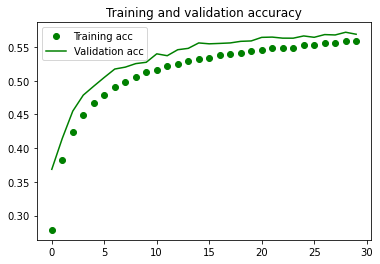

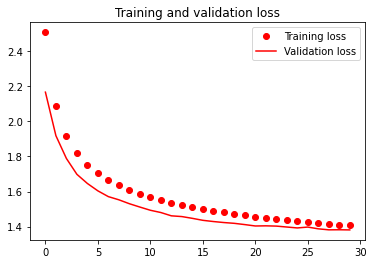

In [178]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [179]:
# Save the Model
model_simpleRNN3.save('SeoShinYoun_SimpleRNN3.h5')

## Step 3 – Use the developed Model to generate the characters / sentences

### Load Best Models For LSTM, Bidirectional LSTM, Bidirectional GRU, SimpleRNN

In [180]:
finalLSTM = keras.models.load_model('SeoShinYoun_LSTM6.h5')

In [181]:
finalBidirectionalLSTM = keras.models.load_model('SeoShinYoun_BidirectLSTM6.h5')

In [182]:
finalBidirectionalGRU = keras.models.load_model('SeoShinYoun_BidirectGRU5.h5')

In [183]:
finalSimpleRNN = keras.models.load_model('SeoShinYoun_SimpleRNN3.h5')

The RNN models have been trained on Harry Potter and the Philosopher's Stone (Book 1)


Unseen First Paragraph From Harry Potter and the Chamber of Secrets (Book 2):

Not for the first time, an argument had broken out over breakfast at number four, Privet
Drive. Mr. Vernon Dursley had been woken in the early hours of the morning by a loud,
hooting noise from his nephew Harry’s room. 

In [184]:
# takes the user input
text_input = np.array([input()])

Not for the first time, an argument had broken out over breakfast at number four, Privet Drive. Mr. Vernon Dursley had been woken in the early hours of the morning by a loud, hooting noise from his nephew Harry’s room.


In [197]:
text_input

array(['Not for the first time, an argument had broken out over breakfast at number four, Privet Drive. Mr. Vernon Dursley had been woken in the early hours of the morning by a loud, hooting noise from his nephew Harry’s room.'],
      dtype='<U218')

In [209]:
# Length of extracted character sequences
maxlen = 35
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []
text_input_test = str(text_input)
for i in range(0, len(text_input_test) - maxlen, step):
    sentences.append(text_input_test[i: i + maxlen])
    next_chars.append(text_input_test[i + maxlen])
print('Number of sequences:', len(sentences))
for index in range(0,10):
    print('sentences  ['+str(index)+']:' ,sentences[index])
    print('next_chars ['+str(index)+']:',next_chars[index])
    print()

Number of sequences: 63
sentences  [0]: ['Not for the first time, an argume
next_chars [0]: n

sentences  [1]: ot for the first time, an argument 
next_chars [1]: h

sentences  [2]: for the first time, an argument had
next_chars [2]:  

sentences  [3]:  the first time, an argument had br
next_chars [3]: o

sentences  [4]: e first time, an argument had broke
next_chars [4]: n

sentences  [5]: irst time, an argument had broken o
next_chars [5]: u

sentences  [6]: t time, an argument had broken out 
next_chars [6]: o

sentences  [7]: ime, an argument had broken out ove
next_chars [7]: r

sentences  [8]: , an argument had broken out over b
next_chars [8]: r

sentences  [9]: n argument had broken out over brea
next_chars [9]: k



In [249]:
testing = sentences[40]
print(testing)

 been woken in the early hours of t


### Final LSTM Model

In [250]:
# Select a text seed at random
generated_text_initial = testing
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = finalLSTM.predict(sampled, verbose=0)[0] # to get the softmax output
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: " been woken in the early hours of t"
------ temperature: 0.1
 been woken in the early hours of the stone and the stone that be a stand and the stand and the stand and the stone say harry and the stand of the stand of the stone and the stand of the stone be the stand of the stand the stone and the house the stand and the stone and the stone be a stand and the stone and start to have not the stand and the stand and the stand of the stone the stone the stand of the stand of the stand of the sto
------ temperature: 0.3
 been woken in the early hours of the straight that be a people start and he say the stone in the straight they be not to the next teachers harry have she be a stand at the stome and say harry and the hat they be a sharply pass harry have tell him a boy what have not have to be tell him harry be say harry be not to harry the stand and she be a sand and something to have not do not start to get the three of the beard at him and ron 
------ temperatu

### Final Bidirectional LSTM Model

In [251]:
# Select a text seed at random
generated_text_initial = testing
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = finalBidirectionalLSTM.predict(sampled, verbose=0)[0] # to get the softmax output
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: " been woken in the early hours of t"
------ temperature: 0.1
 been woken in the early hours of the stor the boy the back to the boy the boy the back to the boy a store him the boy the stor the corridor they be be that they be be that be he be be be be be that be the back to him they be be say the stall be the boy the that they be be that so they be say the corridor they be be that they be be be be be he stop the back to the boy the stor harry be be be start to be harry have to be to the boy 
------ temperature: 0.3
 been woken in the early hours of the head to the hangle him off the street that they say the boy the boy the boy be back to work stop to him into you be start in the hat something and him and him the storice a back to say the corridor because and a back a a corridor and the state of anything his go thangle the house in the break to the school be want to wake and the book and they could could be do they have try to be though the do
------ temperatu

### Final Bidirectional GRU Model

In [252]:
# Select a text seed at random
generated_text_initial = testing
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = finalBidirectionalGRU.predict(sampled, verbose=0)[0] # to get the softmax output
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: " been woken in the early hours of t"
------ temperature: 0.1
 been woken in the early hours of the stand the stand the star the stand the staircase the staircase the stand the stone and the staircase the stand the strain and the stand the stand the stand the stand the stand the stand the staircase the stand the start to the staircase the stand the staircase the staircase the stand he be the stand he be the stand the stand the stand the stand the stand the stone and the stand the stand the st
------ temperature: 0.3
 been woken in the early hours of the heartstay harry say hagrid be harry have to get the in the corridor they be a back to the start he have silepel he be the star and the second he would not start he have have the that be a should not see the staircase they when the way to the stand be the corridor be a broom harry with the stand his back at the same spell i be find the move they have could not be a look say harry have a fatter i
------ temperatu

### Final SimpleRNN Model

In [253]:
# Select a text seed at random
generated_text_initial = testing
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = finalSimpleRNN.predict(sampled, verbose=0)[0] # to get the softmax output
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: " been woken in the early hours of t"
------ temperature: 0.1
 been woken in the early hours of the stop the street the start to harry have get the start the come the corridor say harry and the start to harry say harry be the stop and say harry have get the stop the stop the could not have a past the start the corridor harry start to he say harry and the stop the stop the stop the corridor and say harry be start the corner the stop the corridor harry have a lot the corridor and say harry and 
------ temperature: 0.3
 been woken in the early hours of the stop the table the strict harry and the cloak and the back to the more in the could the dursley harry say harry be the letter the door and harry the stop the could have a lot and the teachers he the start to find the corridor that have a smill the strain and the stop and they say harry and the heave the dursleys the corridor be a be go to the potter he say harry be the cat the dursley have the 
------ temperatu

### THE END